In [1]:
import numpy as np

from scipy import optimize

import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
%matplotlib inline

from sklearn.preprocessing import PolynomialFeatures

import csv

import time

%load_ext autoreload
%autoreload 2

# 1 Univariate Logistic Regression

In [2]:
file_path_1 = '../course_materials/ex2data1.txt'

# 1.1 Data Visualisation

In [3]:
dF_1 = pd.read_csv(file_path_1, header = None, names = ['x1', 'x2', 'y'])
n_samples_1, n_variables_1 = dF_1.shape
print (f"\tn_samples # {n_samples_1}\n\tvariables # {n_variables_1}")
dF_1.head()

	n_samples # 100
	variables # 3


,x1,x2,y
0,34.623660,78.024693,0
1,30.286711,43.894998,0
2,35.847409,72.902198,0
3,60.182599,86.308552,1
4,79.032736,75.344376,1


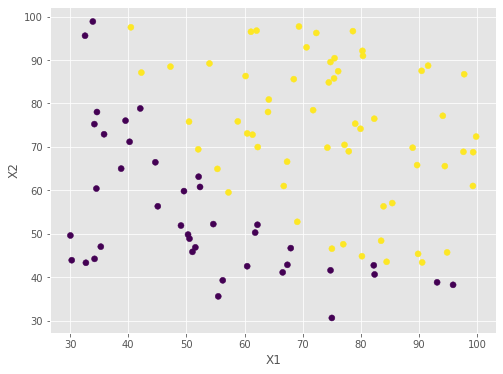

In [4]:
x1 = dF_1['x1']
x2 = dF_1['x2']
plt.figure(figsize=(8,6))
plt.scatter(x1, x2, c = dF_1['y'])
plt.xlabel("X1")
plt.ylabel("X2")
plt.show()

## 1.2 Data Extraction and Transformation

In [5]:
def get_data(file_path):
#     try wiht matrices as well
    data = np.loadtxt(file_path, delimiter = ',')
    n_samples, n_variables = data.shape
    X = np.insert(data[:, :-1], 0, 1, axis=1)
    y = data[:, -1:]
#     β = np.matrix(np.zeros(n_variables)).T
    β = np.zeros(n_variables)
    return β, X.flatten(), y.flatten(), n_samples, n_variables

## 1.3 Logistic Regression
### 1.3.1 Logistic Regression

**Sigmoid Function** ${\σ}(z) = \frac{1}{1 + e^{-z}}$


### 1.3.2 Vectorisation of Logistic Regression

**Hypothesis** $h_{\beta}(X) =   \frac{1}{1 + e^{X\cdot\beta}}$

**Cost Function** $J = \frac{-1}{n}\sum(y^T\cdot \log h_{\beta} +(1-y)^T\cdot \log (1-h_{\beta}))$

In [6]:
def get_sigmoid(z):
    return 1/(1 + np.exp(-z))

def get_hypothesis(β, X, n_samples, n_variables):
    β = β.reshape(n_variables, -1)
    X = X.reshape(n_samples, -1)
    return get_sigmoid(np.dot(X, β))

# def cost_function(X, y, β):
def cost_function(β, X, y, n_samples, n_variables, λ=0.):
#     β = β.reshape(n_variables, -1)
#     X = X.reshape(n_samples, -1)
    y = y.reshape(n_samples, -1)
#     hypothesis vector h(n, 1)
    h = get_hypothesis(β, X, n_samples, n_variables)
#     cost scalar J(1, 1)
    J = (- np.dot(y.T, np.log(h)) - np.dot((1-y).T, np.log(1-h)))/n_samples
#     similarly cost J can be calculated using np.multiply together with np.sum
#     cost = -np.sum(np.multiply(y, np.log(h)) + np.multiply((1-y), np.log(1-h)))/n_samples
#     regularisation scalar (R)
    R = λ*np.dot(β[1:].T,β[1:])/(2*n_samples)
    return (J + R)[0][0]

def optimise_β_1 (β, X, y, n_samples, n_variables, λ=0.):
    return optimize.fmin(cost_function, x0=β, args=(X, y, n_samples, n_variables, λ), maxiter=1500, full_output=True)

def get_prediction(β, X, n_samples, n_variables):
    return get_hypothesis(β, X, n_samples, n_variables) >= 0.5


## 1.4 Function Tests

In [7]:
β_test_1, X_1, y_1, n_samples_1, n_variables_1 = get_data(file_path_1)
y_1.shape

(100,)

### 1.4.1 Cost-Function Test
The outputs of the cost_function should be as follows:<br\>
β_test (set to zeros), X, λ=0. — **J = 0.693** (Andrew Ng) <br\>

In [8]:
J = cost_function(β_test_1, X_1, y_1, n_samples_1, n_variables_1)
print(f"\tJ = {J:.5f}")

	J = 0.69315


### 1.5.1 Prediction Test
The outputs of the cost_function should be as follows:<br\>
Exam_1: 45, Exam_2: 85 — **P = 0.776** (Andrew Ng) <br\>

In [9]:
β_opt_1 = optimise_β_1(β_test_1, X_1, y_1, n_samples_1, n_variables_1)[0]
xTest_1 = np.array([1, 45, 85])
n_samplesTest_1 = 1
hypothesis = get_hypothesis(β_opt_1, xTest_1, n_samplesTest_1, n_variables_1)[0][0]
print(f"\tP = {hypothesis:.5f}")

Optimization terminated successfully.
         Current function value: 0.203498
         Iterations: 157
         Function evaluations: 287
	P = 0.77629


## 1.5 Results Visualisation & Analysis
### 1.5.1 Goodness of _fit Measures
#### 1.5.1.1 Decision Boundary
This comment is here thanks to this dude (https://github.com/vsevolodloik).<br />
Decision boundary is defined as follows:<br />
$\frac{1}{1 + e^{X\cdot\beta}} = \frac{1}{2}$<br />
Therefore, for the simple case of two variables, the equation of decision boundary takes the following form:<br />
$\beta_0+\beta_1\cdot{X_1}+\beta_2 \cdot{X_2} = 0$
#### 1.5.1.2 Types of Errors & Accuracy, Precision, Recal

The rate **type I error** (false positives) is denoted by $\alpha$.<br />
The rate **type II error** (false negatives) is denoted by $\beta$.<br /><br />
* **Accuracy** $= \frac {TP + TN}{TP + TN + FP + FN}$
* **Precision** $= \frac {TP}{TP + FP}$
* **Recall** $= \frac {TP}{TP + FN}$

In [10]:
def get_accurary_precision_recall(
        X, y, p):
    #     Elegant way to calculate TP, FP, and FN
    tp = np.sum(y * p)
    fp = np.sum(y - p == -1)
    fn = np.sum(y - p == 1)
    accuracy = (X.shape[0] - fp - fn)/X.shape[0]
    precision  = tp / (tp + fp)
    recall  = tp / (tp + fn)
    print(f"\taccuracy {accuracy:.3f}\n\tprecision {precision:.3f}\n\trecall {recall:.3f}")
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall}

def goodness_of_fit(β, X, y, n_samples, n_variables):
    β_R = β.reshape(n_variables, -1)
    X_R = X.reshape(n_samples, -1)
    y_R = y.reshape(n_samples, -1)
    p = get_prediction(β, X, n_samples, n_variables).flatten()
    
    get_accurary_precision_recall(X, y, p)
    
    plt.figure(figsize=(8,6))
    x1 = X_R[:, 1:2]
    x2 = X_R[:, 2:]
    plt.scatter(x1, x2, c = y_R[:, 0:])
    x2_fit = - β_R[0]/β_R[2] - x1*β_R[1]/β_R[2]
    plt.plot(x1, x2_fit, '-')
    plt.xlabel("X1")
    plt.ylabel("X2")
    return plt.show()

	accuracy 0.963
	precision 0.902
	recall 0.917


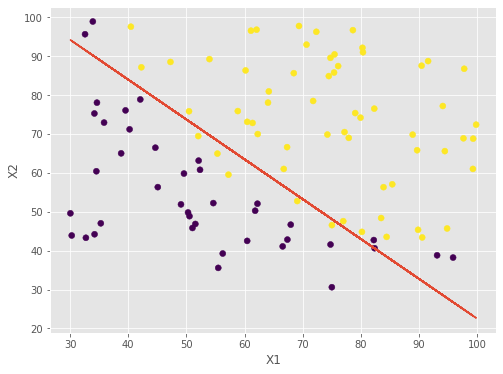

In [11]:
goodness_of_fit(β_opt_1, X_1, y_1, n_samples_1, n_variables_1)

http://www.johnwittenauer.net/tag/machine-learning/

http://aimotion.blogspot.se/2011/11/machine-learning-with-python-logistic.html

https://beckernick.github.io/logistic-regression-from-scratch/

https://github.com/kaleko/CourseraML/blob/master/ex2/ex2.ipynb

http://www.scipy-lectures.org/advanced/mathematical_optimization/

# 2 Multivariate Logistic Regression

In [12]:
file_path_2 = '../course_materials/ex2data2.txt'
dF_2 = pd.read_csv(file_path_2, header = None)
n_samples, n_variables = dF_2.shape
print (f"\tsamples # {n_samples}\n\tvariables # {n_variables}")
dF_2.head()

	samples # 118
	variables # 3


,0,1,2
0,0.051267,0.69956,1
1,-0.092742,0.68494,1
2,-0.213710,0.69225,1
3,-0.375000,0.50219,1
4,-0.513250,0.46564,1


## 2.1 Data Visualisation

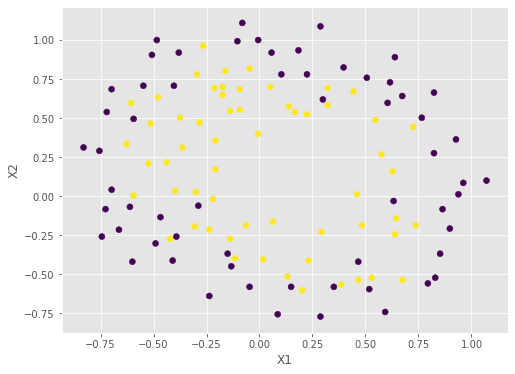

In [13]:
X_1s = dF_2.iloc[:, :1]
X_2s = dF_2.iloc[:, 1:2]
plt.figure(figsize=(8,6))
plt.scatter(X_1s, X_2s, c = dF_2.iloc[:, 2:])
plt.xlabel('X1')
plt.ylabel('X2')
plt.show()

## 2.2 Data Extraction Transformation
Add **polynomial** and **interaction** features using **SciKitLearn Preprocessing**<br\>
http://scikit-learn.org/stable/modules/getd/sklearn.preprocessing.PolynomialFeatures.html

In [14]:
def add_polynomial(file_path, polynomialDegree):
    data = np.loadtxt(file_path, delimiter = ',')
    n_samples, n_variables = data.shape
    X = data[:, :-1]
    y = data[:, -1:]
    poly = PolynomialFeatures(polynomialDegree)
#     X without intercept is passed to PolynomialFeatures.fit_transform.
#     Intercept is added automatically.
    poly_X = poly.fit_transform(X)
    n_samples, n_variables = poly_X.shape
    β = np.zeros((n_variables,1))
    return β.flatten(), poly_X.flatten(), y.flatten(), n_samples, n_variables

## 2.3 Function Tests

In [15]:
βPoly6, XPoly6, yPoly6, n_samplesPoly6, n_variablesPoly6 = add_polynomial(file_path_2, 6)

### 2.3.1 Cost-Function Test
The outputs of the cost_function should be as follows:<br\>
β_test (set to zeros), X, λ=0. — **J = 0.693** (Andrew Ng) <br\>

In [16]:
J = cost_function(βPoly6, XPoly6, yPoly6, n_samplesPoly6, n_variablesPoly6)
print(f"J = {J:.5f}")

J = 0.69315


In [17]:
def optimise_β_2(β, X, y, n_samples, n_variables, λ=0.):
#     Number of iterations significantly affects the output of this function
    β_optimised = optimize.minimize(cost_function, β, args=(X, y, n_samples, n_variables, λ),
                                      method='BFGS', options={'maxiter':200, "disp":False})

#     β_optimised = optimize.fmin_cg(cost_function, fprime=back_propagation, x0=β_flat,
#                                      args=(layer, X_flat, n_samples, y, yUnique),
#                                      maxiter=50,disp=True,full_output=True)
    return(β_optimised['x'])

In [18]:
# β_opt = optimise_β(βPoly6, XPoly6, yPoly6, λ = 0.)[0]

## 2.4 Results Visualisation & Analysis

In [19]:
def decision_boundary(β, X, y, n_samples, n_variables, xMin, xMax, step, polyOrder, λ=0.):
    p = get_prediction(β, X, n_samples, n_variables).flatten()
    get_accurary_precision_recall(X, y, p)
    
    xx = np.linspace(xMin[0], xMax[0], step)
    yy = np.linspace(xMin[1], xMax[1], step)
    XX, YY = np.meshgrid(xx, yy)
    XY = np.concatenate((XX.reshape(step**2, -1), YY.reshape(step**2, -1)), axis=1)
#     X without intercept is passed to PolynomialFeatures.fit_transform.
#     Intercept is added automatically.
    poly = PolynomialFeatures(polyOrder)
    poly_XY = poly.fit_transform(XY)
    ZZ = get_hypothesis(β, poly_XY, step**2, poly_XY.shape[1]).reshape(step, -1)
#     ZZ = prediction(β, poly_XY, step**2, poly_XY.shape[1]).reshape(step, -1)
#     For plt.contour, ZZ is a matrix
#     xx(XX) and yy(YY) can be either matrices or vectors of appropriate dimensions
    decision_boundary = plt.contour(xx, yy, ZZ, [0.5])
    plt.clabel(decision_boundary, inline=1, fontsize=15, fmt = '$\lambda $= %d'%λ)

    x_1 = X.reshape(n_samples,-1)[:, 1:2]
    x_2 = X.reshape(n_samples,-1)[:, 2:3]
    plt.scatter(x_1, x_2, c = y.reshape(n_samples,-1)[:, 0:])
    plt.title("Decision Boundary")
    plt.xlabel("X1")
    plt.ylabel("X2")
    return plt.show()

	accuracy 0.995
	precision 0.828
	recall 0.914


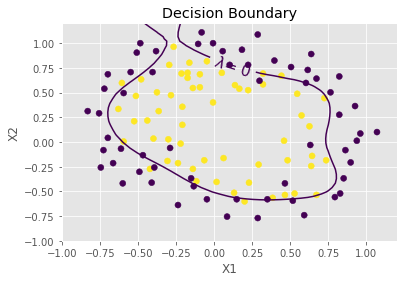

In [20]:
λ = 0
polyOrder = 6
βPoly, XPoly, yPoly, sS_Poly, nV_Poly = add_polynomial(file_path_2, polyOrder)
β_opt_2 = optimise_β_2(βPoly, XPoly, yPoly, sS_Poly, nV_Poly, λ)

xMin = (-1., -1.)
xMax = (1.2, 1.2)
step = 50
decision_boundary(β_opt_2, XPoly, yPoly, sS_Poly, nV_Poly, xMin, xMax, step, polyOrder, λ)

	accuracy 0.995
	precision 0.828
	recall 0.914


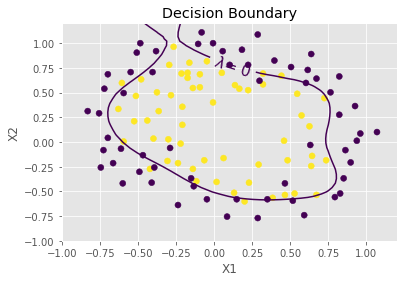

	accuracy 0.994
	precision 0.779
	recall 0.914


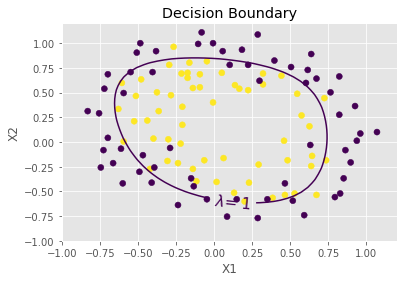

	accuracy 0.991
	precision 0.694
	recall 0.862


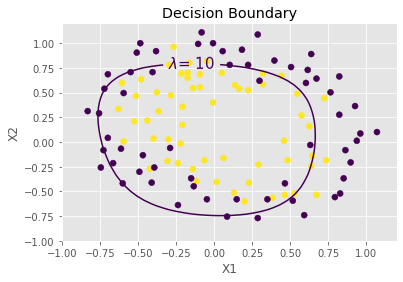

	accuracy 0.986
	precision 0.643
	recall 0.466


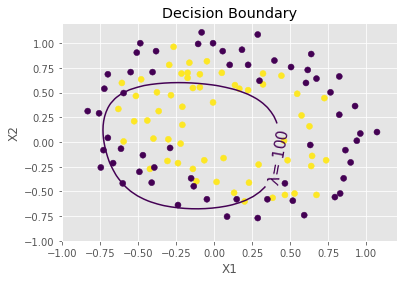

In [21]:
for i, λ in enumerate([0., 1., 10, 100 ]):
    polyOrder = 6
    βPoly, XPoly, yPoly, n_samplesPoly, n_variablesPoly = add_polynomial(file_path_2, polyOrder)
    β_opt = optimise_β_2(βPoly, XPoly, yPoly, n_samplesPoly, n_variablesPoly, λ)
    xMin = (-1., -1.)
    xMax = (1.2, 1.2)
    step = 50
    decision_boundary(β_opt, XPoly, yPoly, n_samplesPoly, n_variablesPoly, xMin, xMax, step, polyOrder, λ)